# Titanic Project
The goal is to correctly predict if someone survived the Titanic shipwreck. At the end I created a web API to predict which passengers died or not.

**Best results : 83.7 % accuracy**

## Overview
### 1) Data Exploration and Cleaning

### 2) Feature Engineering

### 3) Data Preprocessing for Model

### 4) Basic Model Building

### 5) Model Tuning

### 6) Ensemble Model Building

### 7) Results

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# custom estimator
from custom_estimators import FeatureSelector, IsAlone, ExtractName

In [2]:
sns.set(style = 'ticks')
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 144

# Data Exploration and Cleaning

First we load the datasets.

In [3]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

## Observations and Assumptions

In [81]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Checking basic info on the datasets

In [4]:
train.shape, test.shape

((891, 12), (418, 11))

In [5]:
train.info(), print(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass 

(None, None, None)

Checking missing values.

In [7]:
train.isna().any(), print(), test.isna().any()

(PassengerId    False
 Survived       False
 Pclass         False
 Name           False
 Sex            False
 Age             True
 SibSp          False
 Parch          False
 Ticket         False
 Fare           False
 Cabin           True
 Embarked        True
 dtype: bool,
 None,
 PassengerId    False
 Pclass         False
 Name           False
 Sex            False
 Age             True
 SibSp          False
 Parch          False
 Ticket         False
 Fare            True
 Cabin           True
 Embarked       False
 dtype: bool)

**Variables with missing values:**
train: *Age, Cabin and Embarked*
test: *Age, Fare and Cabin*
Let us continue to find out more about missing values.

In [8]:
def count_na(df, columns):
    '''
    Count the missing values by column.

    Parameters:
        df: dataframe
        columns: columns of the dataframe
    Returns: Number of missing values by column
    '''

    counts = [(df[col].isna() == 1).sum() for col in columns]
    print([(columns[i], counts[i]) for i in range(len(columns))])


In [10]:
# Number of missing values in train_data
count_na(train, ['Age', 'Cabin', 'Embarked'])

#Number of missing values in test_data
count_na(test, ['Age', 'Cabin', 'Fare'])

[('Age', 177), ('Cabin', 687), ('Embarked', 2)]
[('Age', 86), ('Cabin', 327), ('Fare', 1)]


In [11]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
train.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [13]:
train['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
whole_data = pd.concat([train,test])

%matplotlib inline
whole_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [15]:
train.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'train_test'],
      dtype='object')

In [16]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

## Data Exploration and cleaning
#### 1) We compare each feature with the survived column to see how it affected the survival of the passengers.

#### 2) First seperate the columns into categorical and numerical and look at them individually.

#### 3) Look at correlations in the data.

#### 4) For each column, look at the records in it that survived or not.

#### 1) We compare each feature with the survived column to see how it affected the survival of the passengers.
### Pclass vs. Survived

In [18]:
train[['Pclass', 'Survived']].groupby('Pclass').mean().sort_values(by='Survived', ascending = False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


Passengers in 1st class are more likely to survive by 62.9% more than others apparently. Always when you can buy first class tickets :).

### Fare vs. Survived

In [40]:
train.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: Fare, Length: 248, dtype: int64

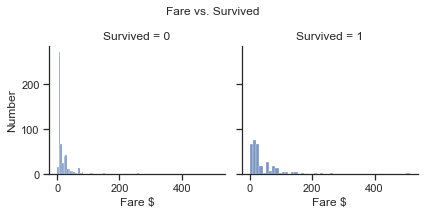

In [45]:
g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.histplot, 'Fare', bins = 50, kde = False)
g.set_axis_labels('Fare $','Number')
g.fig.subplots_adjust(top = 0.8)
g.fig.suptitle("Fare vs. Survived")
plt.show()

### Sex vs. Survived

In [46]:
train[['Sex', 'Survived']].groupby('Sex').mean().sort_values('Survived', ascending = False)

,Survived
Sex,
female,0.742038
male,0.188908


Females have a higher chance of surviving than males.

In [51]:
### Age vs. Survived

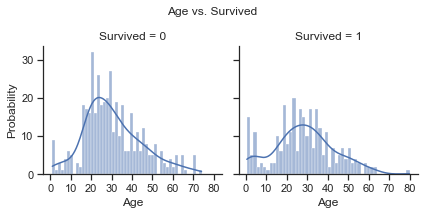

In [52]:
ticks = [i for i in np.arange(0, 90, 10)]
g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.histplot, 'Age', bins = 50, kde= True)
g.set(xticks = ticks)
g.set_axis_labels('Age','Probability')
g.fig.subplots_adjust(top = 0.8)
g.fig.suptitle("Age vs. Survived")
plt.show()

From 0-10 years, passengers mostly survived.
From 20 - 40 years, passengers mostly died.
At 75+ years, it seems like all of them survived. We will keep 'Age' in the model.

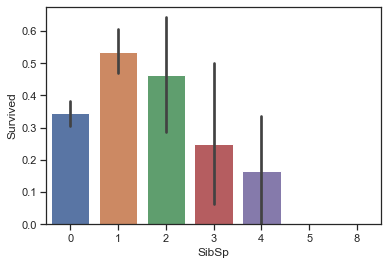

In [54]:
sns.barplot(x = train['SibSp'], y = train['Survived'])
plt.show()

It seems like the more you had siblings or spouses, the lesser chances to survive you had excluding 0 sibsp which is a little lower. Anyway let's continue.

### Parch vs. Survived

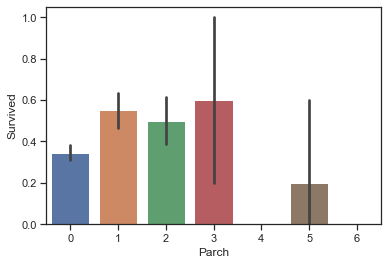

In [58]:
sns.barplot(x = train['Parch'], y = train['Survived'])
plt.show()

It seems like travelling alone wasn't recommended either because those with parch = 0 and sibsp = 0 have low survival rates.

### Embarked vs. Survived

In [59]:
train[['Embarked', 'Survived']].groupby('Embarked').mean().sort_values(by = 'Survived', ascending = False)

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


Cherbourg passengers survived at a better rate than the rest.

### Sex, Pclass, Embarked vs. Survived

C:\Users\kamga\PycharmProjects\scientificProject\venv\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\kamga\PycharmProjects\scientificProject\venv\lib\site-packages\seaborn\axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


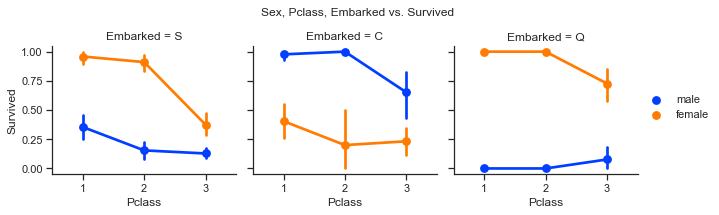

In [62]:
g = sns.FacetGrid(train, col = 'Embarked')
g.map(sns.pointplot,'Pclass' ,'Survived', 'Sex', palette = 'bright')
g.fig.subplots_adjust(top = 0.8)
g.fig.suptitle("Sex, Pclass, Embarked vs. Survived")
g.add_legend()
plt.show()

644 passengers embarked at S(most of them) so in average males have a lower survival rate than females.

### Age, Pclass vs. Survived

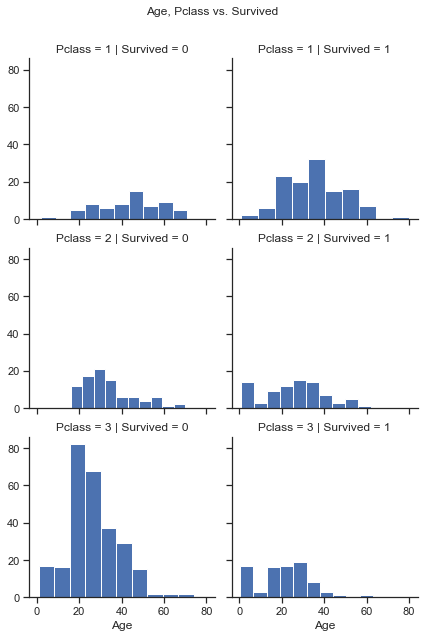

In [65]:
g = sns.FacetGrid(train, row = 'Pclass', col = 'Survived')
g.map(plt.hist, 'Age')
g.fig.subplots_adjust(top = 0.9)
g.fig.suptitle("Age, Pclass vs. Survived")
plt.show()

The 3rd class has the highest casualties

### Heatmap

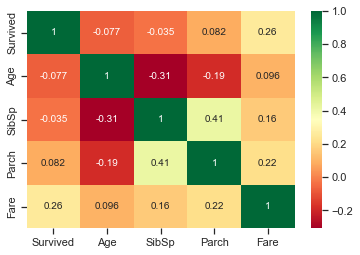

In [66]:
sns.heatmap(train[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']].corr(), annot=True, cmap='RdYlGn')
plt.show()

Since SipSp and Parch seem to be somewhat correlated, we remove them to reduce the noise in our model.

### Name

We extract each passenger's title

In [67]:
title = [i.split(",")[1].split(".")[0].strip() for i in train["Name"]]
title = Counter(title)
title

Counter({'Mr': 517,
         'Mrs': 125,
         'Miss': 182,
         'Master': 40,
         'Don': 1,
         'Rev': 6,
         'Dr': 7,
         'Mme': 1,
         'Ms': 1,
         'Major': 2,
         'Lady': 1,
         'Sir': 1,
         'Mlle': 2,
         'Col': 2,
         'Capt': 1,
         'the Countess': 1,
         'Jonkheer': 1})

Let's categorize it as follows:
* Mr/Master: 0
* Mrs/Miss: 1
* Others: 2

**Here is what we are going to do for the feature engineering.**

1. Drop out
    PassengerId(irrelevant),
    Name(feature engineered),
    Ticket(irrelevant) and
    Cabin(irrelevant and too many NaNs).
2. Create a new feature 'IsAlone'( = SibSp + Parch + 1) to indicate if a passenger is alone.
3. Extract titles from Name.
4. Missing value imputation and normalization for numerical features.
5. Encode the categorical features.

# Feature Engineering

**All feature transformers are done in custom_estimators.py.**

# Modeling

## Creating the pipeline

In [69]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
train_test       0
dtype: int64

In [70]:
# 'Embarked' has only two missing values
train['Embarked'].fillna(value = train['Embarked'].value_counts().index[0], inplace=True)
X = train.drop('Survived', axis = 1)
y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [71]:
num_columns = ['Age', 'Fare']
cat_columns = ['Pclass', 'Sex', 'Embarked', 'IsAlone', 'Title'] # We will create the features 'IsAlone' and 'Title'

In [73]:
num_pipe = Pipeline([('num_selector', FeatureSelector(num_columns)),
                     ('imputer', SimpleImputer(strategy = 'median')),
                     ('Normalization', StandardScaler())])

In [74]:
cat_pipe = Pipeline([('cat_selector', FeatureSelector(cat_columns)),
                     ('ohe', OneHotEncoder(sparse = False))])

In [75]:
union = FeatureUnion([('num', num_pipe),
                      ('cat', cat_pipe)])

In [88]:
#Seperate numeric and categorical variables. For example Survived and Pclass are categorical although they appear in describe() method.
df_nume = train[['Age', 'SibSp', 'Parch', 'Fare']]
df_cate = train[[ 'Survived',  'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']]

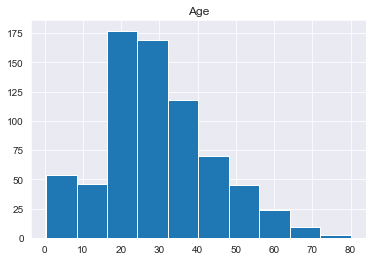

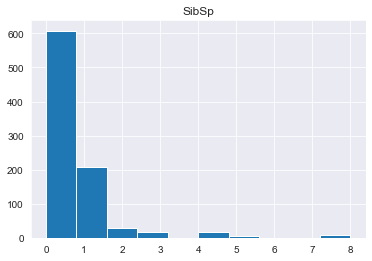

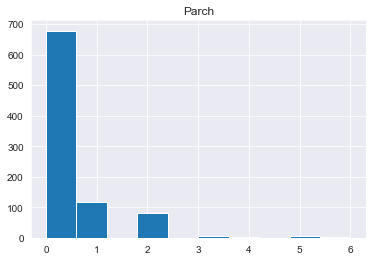

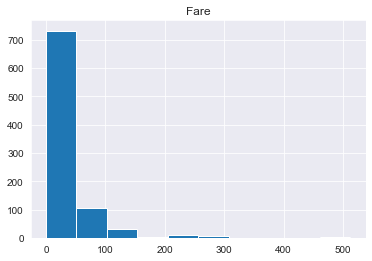

In [89]:
for elt in df_nume.columns:
    plt.hist(df_nume[elt])
    plt.title(elt)
    plt.show()

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


<AxesSubplot:>

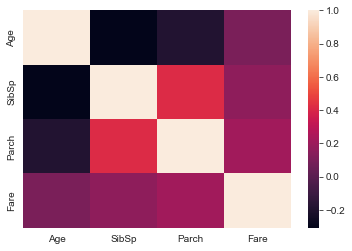

In [91]:
print(df_nume.corr())
sns.heatmap(df_nume.corr())

In [92]:
#See the survival rate accross the numeric columns
train.groupby('Survived')[['Age','SibSp','Parch','Fare']].mean()

,Age,SibSp,Parch,Fare
Survived,,,,
0,30.626179,0.553734,0.329690,22.117887
1,28.343690,0.473684,0.464912,48.395408


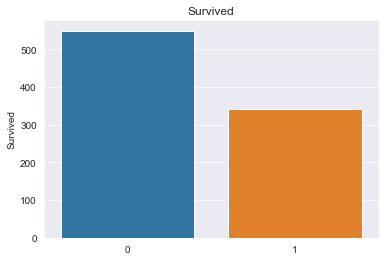

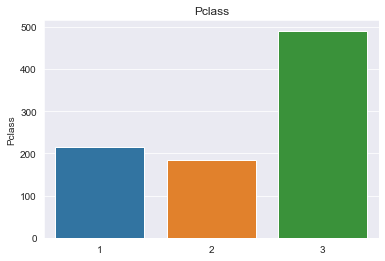

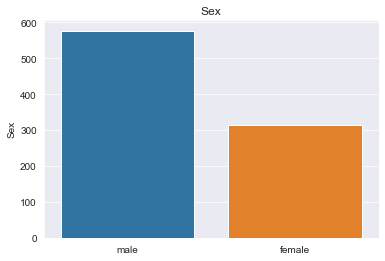

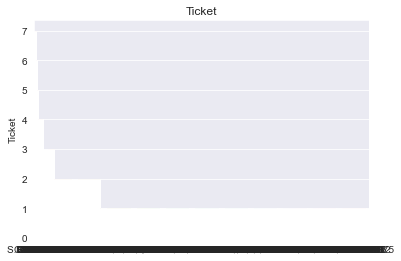

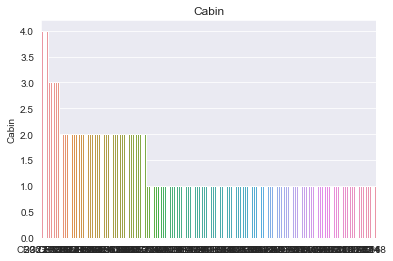

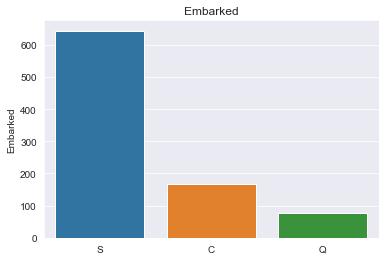

In [93]:
for elt in df_cate.columns:
    sns.barplot(x=df_cate[elt].value_counts().index, y=df_cate[elt].value_counts()).set_title(elt)
    plt.show()

To reduce processing time, we would rather look up Cabin and Ticket value counts seperately since they mostly have unique values.

In [94]:
df_cate.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [95]:
df_cate.Ticket.value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [96]:
# Comparing survival and each of these categorical variables
print(train.groupby(['Survived', 'Pclass'])['Ticket'].count())

print()
print(train.groupby(['Survived', 'Sex'])['Ticket'].count())
print()
print(train.groupby(['Survived', 'Embarked'])['Ticket'].count())

Survived  Pclass
0         1          80
          2          97
          3         372
1         1         136
          2          87
          3         119
Name: Ticket, dtype: int64

Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
Name: Ticket, dtype: int64

Survived  Embarked
0         C            75
          Q            47
          S           427
1         C            93
          Q            30
          S           217
Name: Ticket, dtype: int64


## Feature Engineering
### 1) Cabin - Simplify cabins (evaluated if cabin letter (cabin_adv) or the purchase of tickets across multiple cabins (cabin_multiple) impacted survival)

### 2) Tickets - Do different ticket types impact survival rates?

### 3) Does a person's title relate to survival rates?

In [97]:
train.Cabin

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

Here we look at people who may have had multiple cabins

In [98]:

train['cabin_multiple'] = train.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
train['cabin_multiple'].value_counts()

0    687
1    180
2     16
3      6
4      2
Name: cabin_multiple, dtype: int64

Then we see how the purchase of multiple cabins may have affected survival.

In [99]:
pd.pivot_table(train, index = 'Survived', columns = 'cabin_multiple', values = 'Ticket' ,aggfunc ='count')

cabin_multiple,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


Let's now compare survival rate based on the cabin letter

In [100]:
train['cabin_adv'] = train.Cabin.apply(lambda x: str(x)[0])

Could we consider better converting the cabin to cabin_adv? For example on the row with PassengerId 700 below. There are two cabins with different first letters of cabins(F and G63. First letters are F and G) but we only pick the first one.

In the most cases anyways, the cabins have just one letter

In [101]:
train[train['cabin_multiple'] > 1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test,cabin_multiple,cabin_adv
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S,1,3,C
75,76,0,3,"Moen, Mr. Sigurd Hansen",male,25.00,0,0,348123,7.6500,F G73,S,1,2,F
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,C23 C25 C27,S,1,3,C
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.00,0,1,PC 17759,63.3583,D10 D12,C,1,2,D
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.00,0,1,PC 17558,247.5208,B58 B60,C,1,2,B
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C,1,2,F
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,1,2,C
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.00,0,1,PC 17558,247.5208,B58 B60,C,1,2,B
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,1,2,C
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,1,4,B


In [102]:
#comparing surivial rate by cabin
#n stands for null
print(train.cabin_adv.value_counts())
pd.pivot_table(train,index='Survived',columns='cabin_adv', values = 'Name', aggfunc='count')

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_adv, dtype: int64


cabin_adv,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


Here we look if the type of tickets played a role in the survival.
For example if there was text or not in the ticket, the type of text and if there were only numbers on the ticket.

Did some of these influence the survival rate?

In [103]:
train['numeric_ticket'] = train.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
train['ticket_letters'] = train.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)

In [104]:
train[['Ticket', 'numeric_ticket', 'ticket_letters']]

,Ticket,numeric_ticket,ticket_letters
0,A/5 21171,0,a5
1,PC 17599,0,pc
2,STON/O2. 3101282,0,stono2
3,113803,1,0
4,373450,1,0
...,...,...,...
886,211536,1,0
887,112053,1,0
888,W./C. 6607,0,wc
889,111369,1,0


In [105]:
train['numeric_ticket'].value_counts()

1    661
0    230
Name: numeric_ticket, dtype: int64

In [106]:
train['ticket_letters'].value_counts()

0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
fcc            5
c              5
sopp           3
pp             3
wep            3
ppp            2
scah           2
sotono2        2
swpp           2
fc             1
scahbasle      1
as             1
sp             1
sc             1
scow           1
fa             1
sop            1
sca4           1
casoton        1
Name: ticket_letters, dtype: int64

In [107]:
#Now the moment everybody has being waiting for. How do numeric tickets affect survival rates?
pd.pivot_table(train,index='Survived',columns='numeric_ticket', values = 'Ticket', aggfunc='count')

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


In [108]:
#How do ticket types affect survival rates?
pd.pivot_table(train,index='Survived',columns='ticket_letters', values = 'Ticket', aggfunc='count')

ticket_letters,0,a4,a5,as,c,ca,casoton,fa,fc,fcc,...,soc,sop,sopp,sotono2,sotonoq,sp,stono2,swpp,wc,wep
Survived,,,,,,,,,,,,,,,,,,,,,
0,410.0,7.0,19.0,1.0,3.0,27.0,1.0,1.0,1.0,1.0,...,5.0,1.0,3.0,2.0,13.0,1.0,10.0,NaN,9.0,2.0
1,255.0,NaN,2.0,NaN,2.0,14.0,NaN,NaN,NaN,4.0,...,1.0,NaN,NaN,NaN,2.0,NaN,8.0,2.0,1.0,1.0


In [109]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test,cabin_multiple,cabin_adv,numeric_ticket,ticket_letters
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,n,0,a5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,C,0,pc
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,n,0,stono2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,C,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,n,1,0


In [110]:
#Get the people's title
train['name_title'] = train.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
#mr., ms., master. etc

In [111]:
train['name_title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: name_title, dtype: int64

In [112]:
#How did different people survive?
pd.pivot_table(train,index='Survived',columns='name_title', values = 'Ticket', aggfunc='count')

name_title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Survived,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,4.0,1.0,NaN,1.0,17.0,55.0,NaN,NaN,436.0,26.0,NaN,6.0,NaN,NaN
1,NaN,1.0,NaN,3.0,NaN,1.0,1.0,23.0,127.0,2.0,1.0,81.0,99.0,1.0,NaN,1.0,1.0


## Data Preprocessing for Model
### 1) Drop null values from Embarked (only 2)

### 2) Include only relevant variables (Since we have limited data, I wanted to exclude things like name and passanger ID so that we could have a reasonable number of features for our models to deal with)
Variables:  'Pclass', 'Sex','Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'cabin_adv', 'cabin_multiple', 'numeric_ticket', 'name_title'

### 3) Do categorical transforms on all data. Usually we would use a transformer, but with this approach we can ensure that our traning and test data have the same colums. We also may be able to infer something about the shape of the test data through this method. This is generally not recommend outside of a competition (use onehot encoder).

### 4) Impute data with mean for fare and age (Should also experiment with median)

### 5) Normalized fare using logarithm to give more semblance of a normal distribution

### 6) Scaled data 0-1 with standard scaler

(889,)

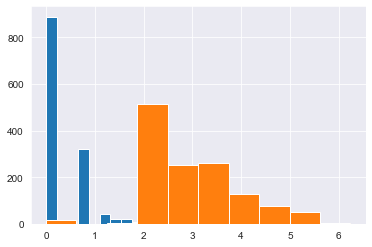

In [113]:
#create all categorical variables that we did above for both train and test sets
whole_data['cabin_multiple'] = whole_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
whole_data['cabin_adv'] = whole_data.Cabin.apply(lambda x: str(x)[0])
whole_data['numeric_ticket'] = whole_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
whole_data['ticket_letters'] = whole_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)
whole_data['name_title'] = whole_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

#impute nulls for continuous data
#whole_data.Age = whole_data.Age.fillna(train.Age.mean())
whole_data.Age = whole_data.Age.fillna(train.Age.median())
#whole_data.Fare = whole_data.Fare.fillna(train.Fare.mean())
whole_data.Fare = whole_data.Fare.fillna(train.Fare.median())

#drop null 'embarked' rows. Only 2 instances of this in training and 0 in test
whole_data.dropna(subset=['Embarked'],inplace = True)

#tried log norm of sibsp (not used)
whole_data['norm_sibsp'] = np.log(whole_data.SibSp+1)
whole_data['norm_sibsp'].hist()

# log norm of fare (used)
whole_data['norm_fare'] = np.log(whole_data.Fare+1)
whole_data['norm_fare'].hist()

# converted fare to string for pd.get_dummies()
whole_data.Pclass = whole_data.Pclass.astype(str)

#created dummy variables from categories (also can use OneHotEncoder)
all_dummies = pd.get_dummies(whole_data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple','numeric_ticket','name_title','train_test']])

#Split to train test again
X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis =1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis =1)


y_train = whole_data[whole_data.train_test==1].Survived
y_train.shape

In [114]:
# Scale data
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])


X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = whole_data[whole_data.train_test==1].Survived

In [121]:
X_test_scaled.loc[0].values

array([ 0.39048774, -0.47953739, -0.44540733, -0.82617242,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

## Model Building (Baseline Validation Performance)
Before going further, I like to see how various different models perform with default parameters. I tried the following models using 5 fold cross validation to get a baseline. With a validation set baseline, we can see how much tuning improves each of the models. Just because a model has a high baseline on this validation set doesn't mean that it will actually do better on the eventual test set.

- Naive Bayes (72.2%)
- Logistic Regression (82.2%)
- Decision Tree (77.7%)
- K Nearest Neighbor (81.0%)
- Random Forest (80.1%)
- **Support Vector Classifier (83.4%)**
- Xtreme Gradient Boosting (82.0%)
- Soft Voting Classifier - All Models (82.5%)
- Hard Voting Classifier - All Models (83.0%)

In [122]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [40]:
#I usually use Naive Bayes as a baseline for my classification tasks
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.66853933 0.70224719 0.75842697 0.74719101 0.73446328]
0.7221735542436362


In [41]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.8258427  0.80898876 0.80337079 0.82022472 0.85310734]
0.8223068621849807


In [42]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.75842697 0.74719101 0.8258427  0.74719101 0.8079096 ]
0.7773122579826065


In [43]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.75842697 0.74719101 0.8258427  0.74719101 0.8079096 ]
0.7773122579826065


In [44]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.76966292 0.79775281 0.80898876 0.82022472 0.85310734]
0.8099473116231829


In [45]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.80337079 0.79213483 0.84831461 0.73595506 0.82485876]
0.8009268075922046


In [46]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.85393258 0.82022472 0.8258427  0.80337079 0.86440678]
0.8335555132355742


In [47]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.82022472 0.81460674 0.85393258 0.79775281 0.81355932]
0.8200152351932963


In [48]:
from sklearn.ensemble import VotingClassifier
voting_clf_soft = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], voting = 'soft')

cv = cross_val_score(voting_clf_soft,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.83707865 0.81460674 0.8258427  0.79775281 0.84745763]
0.8245477051990097


In [49]:
from sklearn.ensemble import VotingClassifier
voting_clf_hard = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], voting = 'hard')

cv = cross_val_score(voting_clf_hard,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.83707865 0.82022472 0.84269663 0.80337079 0.84745763]
0.8301656827270996


In [50]:
voting_clf_hard.fit(X_train_scaled,y_train)
y_hat_base_vc = voting_clf_hard.predict(X_test_scaled).astype(int)
basic_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_base_vc}
base_submission = pd.DataFrame(data=basic_submission)
base_submission.to_csv('base_submission.csv', index=False)

## Model Tuned Performance
After getting the baselines, let's see if we can improve on the indivdual model results!I mainly used grid search to tune the models. I also used Randomized Search for the Random Forest and XG boosted model to simplify testing time.

|Model| Baseline | Tuned Performance |
|-----|----------|-------------------|
|Naive Bayes| 72.2%    | NA                |
|Logistic Regression| 82.2%    | 82.8%             |
|Decision Tree| 77.7%    | NA                |
|K Nearest Neighbor| 81.0%    | 82.9%             |
|Random Forest| 80.1%    | 83.8              |
|Support Vector Classifier| 83.4%    | 83.4%             |
|Xtreme Gradient Boosting| 82.0%    | 82.3%             |


In [123]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [124]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [54]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = None)
best_clf_lr = clf_lr.fit(X_train_scaled,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic Regression
Best Score: 0.8279375357074843
Best Parameters: {'C': 1.623776739188721, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


In [125]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs= None)
best_clf_knn = clf_knn.fit(X_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.8290611312131023
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}


In [126]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 ]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs= None)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
SVC
Best Score: 0.8335555132355742
Best Parameters: {'C': 1, 'gamma': 0.1}


In [128]:
rf = RandomForestClassifier(random_state=1)
param_grid = {'n_estimators': [400, 450, 500, 550],
              'criterion': ['gini'],
              'bootstrap': [False],
              'max_depth': [15, 20, 25],
              'max_features': ['sqrt', 10],
              'min_samples_leaf': [2, 3],
              'min_samples_split': [2, 3]}

clf_rf = GridSearchCV(rf, param_grid=param_grid, cv=3, verbose=True, n_jobs=None)
best_clf_rf = clf_rf.fit(X_train_scaled, y_train)
clf_performance(best_clf_rf, 'Random Forest')

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Random Forest
Best Score: 0.834668001334668
Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 400}


In [68]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [450,500,550],
    'colsample_bytree': [0.75,0.8,0.85],
    'max_depth': [None],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6, .65],
    'learning_rate':[0.5],
    'gamma':[.5,1,2],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 2, verbose = True, n_jobs= None)
best_clf_xgb = clf_xgb.fit(X_train_scaled,y_train)
clf_performance(best_clf_xgb,'XGB')

Fitting 2 folds for each of 243 candidates, totalling 486 fits
XGB
Best Score: 0.8233879947363094
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 2, 'learning_rate': 0.5, 'max_depth': None, 'min_child_weight': 0.01, 'n_estimators': 500, 'reg_alpha': 1, 'reg_lambda': 10, 'sampling_method': 'uniform', 'subsample': 0.65}


<AxesSubplot:>

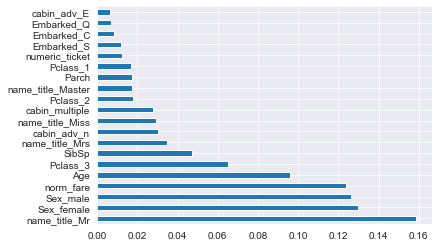

In [69]:
best_rf = best_clf_rf.best_estimator_.fit(X_train_scaled,y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

## Model Additional Ensemble Approaches
1) Experimented with a hard voting classifier of three estimators (KNN, SVM, RF) (81.4%)

2) Experimented with a soft voting classifier of three estimators (KNN, SVM, RF) (81.7%) (best performance in competition leaderboard)

3) Experimented with soft voting on all estimators performing better than 80% except xgb (KNN, RF, LR, SVC) (82.6%)

4) **Experimented with soft voting on all estimators including XGB (KNN, SVM, RF, LR, XGB) (82.8%) (Best Performance)**

Also wanted to test stacked ensembling but due to computational power reasons :) I will stop here for the moment. Maybe someday...

In [ ]:
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_rf = best_clf_rf.best_estimator_
voting_clf_soft = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'soft')

In [70]:
best_lr = best_clf_lr.best_estimator_
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_rf = best_clf_rf.best_estimator_
best_xgb = best_clf_xgb.best_estimator_

voting_clf_hard = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'hard')
voting_clf_soft = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'soft')
voting_clf_all = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('lr', best_lr)], voting = 'soft')
voting_clf_xgb = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('xgb', best_xgb),('lr', best_lr)], voting = 'soft')

print('voting_clf_hard :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5))
print('voting_clf_hard mean :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5).mean())

print('voting_clf_soft :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5))
print('voting_clf_soft mean :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5).mean())

print('voting_clf_all :',cross_val_score(voting_clf_all,X_train,y_train,cv=5))
print('voting_clf_all mean :',cross_val_score(voting_clf_all,X_train,y_train,cv=5).mean())

print('voting_clf_xgb :',cross_val_score(voting_clf_xgb,X_train,y_train,cv=5))
print('voting_clf_xgb mean :',cross_val_score(voting_clf_xgb,X_train,y_train,cv=5).mean())


voting_clf_hard : [0.79213483 0.81460674 0.83146067 0.79775281 0.83615819]
voting_clf_hard mean : 0.8144226496540341
voting_clf_soft : [0.7752809  0.8258427  0.83146067 0.79213483 0.85310734]
voting_clf_soft mean : 0.8166888846568907
voting_clf_all : [0.80898876 0.83146067 0.8258427  0.80337079 0.85875706]
voting_clf_all mean : 0.8256839966990415
voting_clf_xgb : [0.80898876 0.83146067 0.8258427  0.80898876 0.86440678]
voting_clf_xgb mean : 0.8279375357074844


In [73]:
#in a soft voting classifier you can weight some models more than others. I used a grid search to explore different weightings on the soft xgb classifier
#It increased score from 82.8% to 83.7%
params = {'weights' : [[1,1,1,1,1],[2,2,2,2,1],[1,1,1,2,1],[1,2,1,1,1],[1,1,2,1,1],[1,1,1,1,2],[2,2,2,1,2]]}

vote_weight = GridSearchCV(voting_clf_xgb, param_grid = params, cv = 5, verbose = True, n_jobs= None)
best_clf_weight = vote_weight.fit(X_train_scaled,y_train)
clf_performance(best_clf_weight,'VC Weights')
voting_clf_sub = best_clf_weight.best_estimator_.predict(X_test_scaled)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
VC Weights
Best Score: 0.8369453437440487
Best Parameters: {'weights': [1, 2, 1, 1, 1]}


83.7% accuracy after grid search cv. Amazing !!!!!

In [74]:
#Make Predictions
voting_clf_hard.fit(X_train_scaled, y_train)
voting_clf_soft.fit(X_train_scaled, y_train)
voting_clf_all.fit(X_train_scaled, y_train)
voting_clf_xgb.fit(X_train_scaled, y_train)

best_rf.fit(X_train_scaled, y_train)
y_hat_vc_hard = voting_clf_hard.predict(X_test_scaled).astype(int)
y_hat_rf = best_rf.predict(X_test_scaled).astype(int)
y_hat_vc_soft =  voting_clf_soft.predict(X_test_scaled).astype(int)
y_hat_vc_all = voting_clf_all.predict(X_test_scaled).astype(int)
y_hat_vc_xgb = voting_clf_xgb.predict(X_test_scaled).astype(int)

In [75]:
#convert output to dataframe
final_data = {'PassengerId': test.PassengerId, 'Survived': y_hat_rf}
submission = pd.DataFrame(data=final_data)

final_data_2 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_hard}
submission_2 = pd.DataFrame(data=final_data_2)

final_data_3 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_soft}
submission_3 = pd.DataFrame(data=final_data_3)

final_data_4 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_all}
submission_4 = pd.DataFrame(data=final_data_4)

final_data_5 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_xgb}
submission_5 = pd.DataFrame(data=final_data_5)

final_data_comp = {'PassengerId': test.PassengerId, 'Survived_vc_hard': y_hat_vc_hard, 'Survived_rf': y_hat_rf, 'Survived_vc_soft' : y_hat_vc_soft, 'Survived_vc_all' : y_hat_vc_all,  'Survived_vc_xgb' : y_hat_vc_xgb}
comparison = pd.DataFrame(data=final_data_comp)

In [76]:
#prepare submission files
submission.to_csv('submission_rf.csv', index =False)
submission_2.to_csv('submission_vc_hard.csv',index=False)
submission_3.to_csv('submission_vc_soft.csv', index=False)
submission_4.to_csv('submission_vc_all.csv', index=False)
submission_5.to_csv('submission_vc_xgb2.csv', index=False)